In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

######################################
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("compas-scores-two-years-preprocessed.csv", index_col=0)


In [3]:
y = df['two_year_recid'].astype(int)
X = df.drop(columns=['two_year_recid'])

#  Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

#  Make predictions
y_pred = rf.predict(X_test)

Accuracy: 0.86
Precision: 0.83
Recall: 0.76


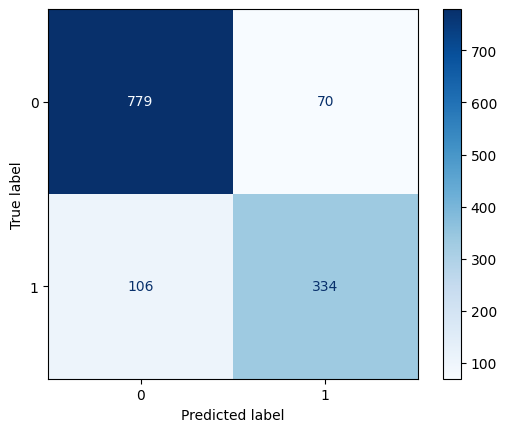

In [4]:
#  Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
disp = ConfusionMatrixDisplay(confusion, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.show()

In [5]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, auc

In [6]:
kfold = KFold(n_splits = 20, shuffle=True)
scores = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy", cv=kfold)
cross_val_accuracy = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy", cv=kfold)
cross_val_accuracy_mean = np.mean(cross_val_accuracy)
cross_val_accuracy_std = np.std(cross_val_accuracy)

print(f"K-fold validation score {scores}")
print(f"Average k-fold validation score : {scores.mean()}")
print(f"Average error on fold: {cross_val_accuracy_mean}")
print(f"Standard error on fold: {cross_val_accuracy_std}")

K-fold validation score [0.89473684 0.87925697 0.87306502 0.88235294 0.81424149 0.89440994
 0.89440994 0.8757764  0.87888199 0.89440994 0.8447205  0.85403727
 0.88198758 0.85093168 0.89440994 0.87888199 0.85714286 0.88198758
 0.8447205  0.89751553]
Average k-fold validation score : 0.8733938426629233
Average error on fold: 0.8763431917389382
Standard error on fold: 0.02003789618710876


In [7]:
kfold = KFold(n_splits = 20, shuffle=True)
scores = cross_val_score(estimator=rf, X=X, y=y, scoring="precision", cv=kfold)
cross_val_precision = cross_val_score(estimator=rf, X=X, y=y, scoring="precision", cv=kfold)
cross_val_precision_mean = np.mean(cross_val_precision)
cross_val_precision_std = np.std(cross_val_precision)

print(f"K-fold validation score {scores}")
print(f"Average k-fold validation score : {scores.mean()}")
print(f"Average error on fold: {cross_val_precision_mean}")
print(f"Standard error on fold: {cross_val_precision_std}")

K-fold validation score [0.81188119 0.89090909 0.87850467 0.79047619 0.89130435 0.89423077
 0.875      0.86868687 0.85294118 0.84722222 0.88349515 0.86607143
 0.94680851 0.9        0.82178218 0.85882353 0.86138614 0.86813187
 0.88118812 0.89010989]
Average k-fold validation score : 0.8689476667487854
Average error on fold: 0.8660514101513739
Standard error on fold: 0.032628598898096696


In [8]:
kfold = KFold(n_splits = 20, shuffle=True)
scores = cross_val_score(estimator=rf, X=X, y=y, scoring="recall", cv=kfold)
cross_val_recall = cross_val_score(estimator=rf, X=X, y=y, scoring="recall", cv=kfold)
cross_val_recall_mean = np.mean(cross_val_recall)
cross_val_recall_std = np.std(cross_val_recall)

print(f"K-fold validation score {scores}")
print(f"Average k-fold validation score : {scores.mean()}")
print(f"Average error on fold: {cross_val_recall_mean}")
print(f"Standard error on fold: {cross_val_recall_std}")

K-fold validation score [0.75229358 0.76842105 0.77678571 0.81308411 0.73504274 0.66055046
 0.79487179 0.7079646  0.81651376 0.76146789 0.88181818 0.78225806
 0.76666667 0.78640777 0.8359375  0.73109244 0.66981132 0.79090909
 0.76315789 0.74766355]
Average k-fold validation score : 0.767135908679662
Average error on fold: 0.7578258727406989
Standard error on fold: 0.04887746980493884


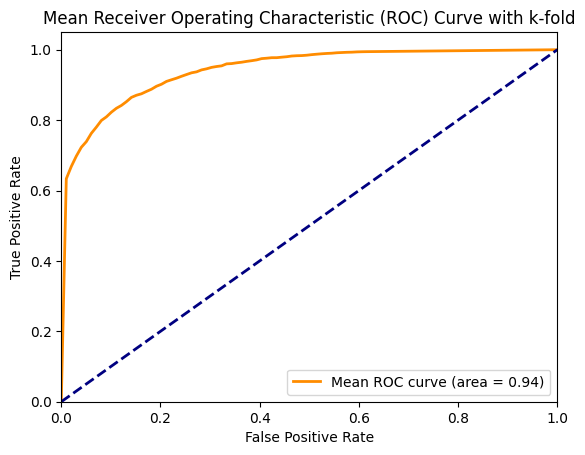

In [9]:
kfold = KFold(n_splits=20, shuffle=True)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for train_index, test_index in kfold.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train_fold, y_train_fold)
    
    proba_matrix_fold = rf.predict_proba(X_test_fold)
    fpr, tpr, thresholds = roc_curve(y_test_fold, proba_matrix_fold[:, 1])
    
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
mean_tpr /= kfold.get_n_splits()

roc_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='Mean ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean Receiver Operating Characteristic (ROC) Curve with k-fold')
plt.legend(loc="lower right")
plt.show()